## Libraries

In [22]:
from keras.layers import TextVectorization
import re
import string
import tensorflow as tf
import os
import pathlib
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from nlpia.loaders import get_data
import numpy as np

## Config

In [36]:
# tanesco
DATASET_PATH ="C:/Users/Tajr/Desktop/UDSM/Experiments/datasets/"
OUTPUT_PATH = "C:/Users/Tajr/Desktop/UDSM/Experiments/textLab/outputs/"

# tesla
# DATASET_PATH ="C:/Users/Tajr/Desktop/textlab/datasets/"
# OUTPUT_PATH = "C:/Users/Tajr/Desktop/textlab/outputs/"

MODEL_PATH = os.path.join(OUTPUT_PATH, 'model/')
IMDB_REVIEWS_PATH = os.path.join(DATASET_PATH, os.listdir(DATASET_PATH)[0])
IMDB_DENSE_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_dense/')
IMDB_LSTM_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_lstm/')
IMDB_GRU_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_gru/')
IMDB_MASKED_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_masked/')
BATCH_SIZE = 32
MAX_TOKENS = 10000
MULTIPLE_CPU = 5
EPOCHS = 10
CHATBOT_EPOCHS = 100
CHATBOT_BATCHSIZE = 64
CHATBOT_NEURONS = 256

## Utils

In [3]:
def get_val_samples():
    base_dir = pathlib.Path(IMDB_REVIEWS_PATH)
    val_dir = base_dir / "val"
    train_dir = base_dir / "train"

    for category in ("neg", "pos"):
        os.makedirs(val_dir / category)
        files = os.listdir(train_dir / category)
        random.Random(1337).shuffle(files)
        num_val_samples = int(0.2 * len(files))
        val_files = files[-num_val_samples:]

        for fname in val_files:
            shutil.move(train_dir / category / fname, val_dir / category / fname)
            
# Accessing data
def inspect_dataset(dataset):
    for inputs, targets in dataset:
        print('inputs.shape: ', inputs.shape)
        print('inputs.dtype: ', inputs.dtype)
        print('targets.shape: ', targets.shape)
        print('targets.dtype: ', targets.dtype)
        print()
        print('Label: {}'.format(targets[0]))
        print('Sample: {}'.format(inputs[0]))
        break

# define and compile your model     
def get_model(max_tokens=MAX_TOKENS, hidden_dim=16):
    # define inputs, hidden layers, and output layer
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # define model
    model = keras.Model(inputs, outputs)
    
    # compile your model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return your model
    return model

# check if output dir exist, if not create it
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Visualize training process
def plot_loss_accuracy(history, file_path):
    # set style
    mkdir(file_path)
    plt.style.use('ggplot')
    (fig, axs) = plt.subplots(2, 1)
    axs[0].plot(history['loss'], label='Training Loss')    
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()    
    axs[1].plot(history['accuracy'], label='Training Accuracy') 
    axs[1].plot(history['val_accuracy'], label='Validation Accuracy')    
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    fig.savefig(file_path)
    plt.show()

## Dataset

Sequential data - any data where the order or sequency is as essential as the data itself. example sentences, stock market data, audio data etc


### Raw data

In [4]:
# get_val_samples()

In [5]:
# These dataset yield inputs that are Tensorflow tf.string tensors and 
# targets are int 32 tensors encoding the value 0 and 1
train_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'train'), batch_size=BATCH_SIZE)
val_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'val'), batch_size=BATCH_SIZE)
test_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'test'), batch_size=BATCH_SIZE)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
# Accessing data
for i, line in enumerate(train_dataset.take(1)):
    print('Label: {}'.format(line[1][2]))
    print('Sample: {}'.format(line[0][2]))
  

Label: 0
Sample: b"in this movie, joe pesci slams dunks a basketball. joe pesci...<br /><br />and being consistent, the rest of the script is equally not believable.<br /><br />pesci is a funny guy, which saves this film from sinking int the absolute back of the cellar, but the other roles were pretty bad. the father was a greedy businessman who valued money more than people, which wasn't even well-played. instead of the man being an archetypal villain, he seemed more like an amoral android programmed to make money at all costs. then there's the token piece that is assigned to pesci as a girlfriend or something...i don't even remember...she was that forgettable.<br /><br />anyone who rates this movie above a 5 or 6 is a paid member of some sort of film studio trying to up the reputation of this sunken film, or at least one of those millions of media minions who can't critique efficiently (you know, the people who feel bad if they give anything a mark below 6).<br /><br />stay away...fa

In [7]:
inspect_dataset(train_dataset)

inputs.shape:  (32,)
inputs.dtype:  <dtype: 'string'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: b'With this movie only running 61 minutes and nothing all that good on television, I decided to pop Revolt of the Zombies into the DVD to pass the time. Even while realizing the era from which it was coming, I was sorely disappointed. It started with the oddly upbeat quality of the opening score (what - no brooding music?) and then the rather slow moving opening sequences. Gosh, I figured a movie about zombies - even from the 1930s - would have SOME chills to it (White Zombie, with Bela Lugosi, certainly did) but this had none. Zero. It was scarcely even dramatic (except for the few moments with the burning eyes superimposed on the film to indicate the mesmerization of someone). Like the equally dull King of the Zombies, this movie may be an interesting curiosity to own, but nothing more.'


## Data Processing

### Standardization, Tokenization and Vectorization

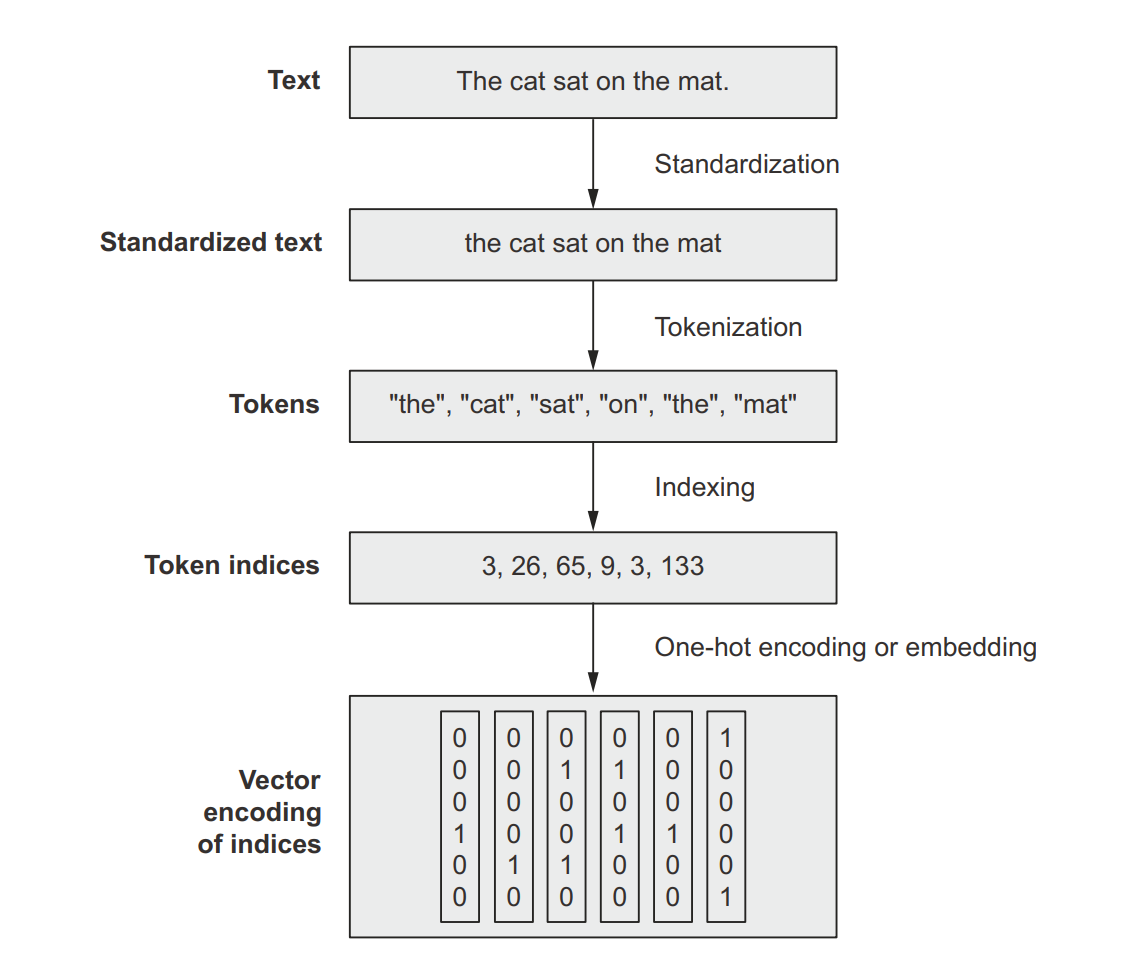

## BAG OF WORDS APPROACH (WORD AS A SET)
- Individual Words(Unigram)
- Group of consecutive tokens(N-grams)

##### Unigram with Binary Encoding

In practice you will use TextVectorization layer which is efficient and fast way of doing things.
- By defauld the layer will use the setting to convert to lowercase and remove punctuation (Standardizaztion), Split on whitespace (tokenization)
- It can receive custom function for standardization and tokenization
- Call adapt method to index the vocabulary of a text corpus

In [8]:
# define vectorizer
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='multi_hot')

In [9]:
# prepare a dataset that only yields raw text inputs no labels
text_only_train_ds = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer.adapt(text_only_train_ds)

In [10]:
# prepare the processed versions of our training validation and test dataset
train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [11]:
inspect_dataset(train_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: [1. 1. 1. ... 0. 0. 0.]


In [12]:
inspect_dataset(val_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [1. 1. 0. ... 0. 0. 0.]


In [13]:
inspect_dataset(test_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [1. 1. 1. ... 0. 0. 0.]


##### Bigrams

###### standardization, tokenization and vectorization

In [14]:
# prepare a dataset that only yield raw text inputs no labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='multi_hot')
vectorizer.adapt(text_only_train_dataset)

In [15]:
# create datasets
btrain_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
bval_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
btest_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [16]:
# inspect dataset
inspect_dataset(btrain_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: [1. 1. 1. ... 0. 0. 0.]


##### Term Frequency, Inverse Document Frequency (TF-IDF)
- it weights a given term by taking term frequency, how many times the term appear in the current document and divide it by a measure of document frequency, which estimates how often the term comes up across the dataset

###### standardization, tokenization and vectorization

In [17]:
# get input text without labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)



In [18]:
for text in text_only_train_dataset:
    print(text)
    break

tf.Tensor(
[b"I wouldn't give this movie a rating, it's not worthy. I watched it only because I'm a Pfieffer fan. I love her and would watch anything she made. Even in this dud, she didn't disappoint. Every scene with her in it, kept the viewer watching...waiting...for something to happen but nothing ever did. It had some good story lines but they ended abruptly as soon as it started. Some of the other characters had potential but nothing became of it.<br /><br />Pfieffer was 29 when she made this film and at her most lovely. The wardrobe and set was surprisingly good. <br /><br />I can watch mostly anything and rarely come across a movie I can't find something to like about it, but this was a dud. I don't understand. <br /><br />The worst thing about it all, it had a big cliff hanger at the end. It had an ending scene that woke you up and say wow, this film is finally going some place, then the credits roll. Good grief. <br /><br />I agree with the review that said .99 would have boug

In [1]:
# vectorize with tf-idf
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='tf_idf')

# Skip GPU execution as dtype=tf.string is not supported for copy btn GPU & CPU
with tf.device('/CPU:0'):
    vectorizer.adapt(text_only_train_dataset)

NameError: name 'TextVectorization' is not defined

In [ ]:
# create datasets
tf_train = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_val = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_test = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [ ]:
# inspect dataset
inspect_dataset(tf_train)

## MODEL

In [ ]:
# define and compile your model
model = get_model()

# get model summary
model.summary()

### Model Training (Unigram)

In [ ]:
# define callbacks if any
callbacks = [
    keras.callbacks.ModelCheckpoint('binary_1gram.keras', save_best_only=True)
]

In [ ]:
# fit or train your model with given datasets
history_dense = model.fit(train_ds.cache(), validation_data=val_ds.cache(), epochs=EPOCHS, callbacks=callbacks)

#### Evaluation

In [ ]:
model = keras.models.load_model('binary_1gram.keras')

In [ ]:
print(f"Test acc: {model.evaluate(test_ds)[1]:.3f}")

In [ ]:
df = pd.DataFrame(data=history_dense.history)
df.describe()

In [ ]:
plot_loss_accuracy(history_dense.history,IMDB_DENSE_OUTPUT)

### Model Training (Bigram)

In [ ]:
bigram_model = get_model()
bigram_model.summary()

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('bigram_model.keras', save_best_only=True)]

In [ ]:
history_bigram_dense = bigram_model.fit(btrain_ds.cache(), validation_data=bval_ds, callbacks=callbacks, epochs=EPOCHS)

#### Evaluation

#### Testing

In [ ]:
model = keras.models.load_model('bigram_model.keras')
print(f"Test acc: {model.evaluate(btest_ds)[1]:.3f}")

#### Visualization

In [ ]:
df = pd.DataFrame(data=history_bigram_dense.history)
df.describe()

In [ ]:
plot_loss_accuracy(history_bigram_dense.history,IMDB_DENSE_OUTPUT)

with bigram, hence local order is pretty important

### Model Training (TF-IDF)

In [ ]:
# get model
tf_model = get_model()
tf_model.summary()

In [ ]:
# callbacks
callbacks = [keras.callbacks.ModelCheckpoint('tf_model.keras', save_best_only=True)]

# train
tf_history = model.fit(tf_train.cache(), validation_data=tf_val.cache(), epochs=EPOCHS, callbacks=callbacks)

### Evaluation

In [ ]:
model = keras.models.load_model('tf_model.keras')
print(f'Test accuracy: {model.evaluate(tf_test)[1]:.3f}')

In [ ]:
df = pd.DataFrame(data=tf_history.history)
df.describe()

### Visualization

In [ ]:
plot_loss_accuracy(tf_history.history,IMDB_DENSE_OUTPUT)

## Exporting a Model that process raw strings

## Inferencing

## THE SEQUENCE MODEL APPROACH  (WORDS AS A SEQUENCE)


### Config

In [ ]:
# In order to keep a managable input size, we will truncate the inputs after the first 600 words
# this is a reasonable choice, since the average review length is 233 words, and only 5% of 
# reviews are longer than 600 words
MAX_LENGTH = 300
EMBEDDING_DIM = 256
HIDDEN_DIM = 32

### Sequence data processiong (One hot encoding

In [ ]:
# Standardization, tokenization and vectorization
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='int', output_sequence_length=MAX_LENGTH)
vectorizer.adapt(text_only_train_dataset)

train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [ ]:
inspect_dataset(train_ds)

### Word Embeddings
- There are two ways to obtain word embeddings
    1. Learn word embeddings jointly with the main task (starts with random word vector)
    2. Load into your model word embeddings that were precomputed using a different machine learning task (pretrained word embeddings)

#### Learn word embeddings with Embedding Layer
- The Embedding layer takes at least two args:
    1. The number f possible tokens. 
    2. The dimensionality of the embeddings.

### MODEL

In [ ]:
# mask_zero param is used to perform input masking which will skip some tokens in time t
def get_lstm_with_embeddings(max_tokens=MAX_TOKENS, hidden_dim=32, mask_zero=False):
    # define
    inputs = keras.Input(shape=(None,), dtype='int64')
    # embedded = tf.one_hot(inputs, depth=max_tokens) # encode the intergers into binary 20000 dimension vector
    embedded = layers.Embedding(input_dim=max_tokens, 
                                output_dim=EMBEDDING_DIM, 
                                mask_zero=mask_zero)(inputs)
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    
    # compile
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return
    return model

In [ ]:
def get_lstm(max_tokens=MAX_TOKENS, hidden_dim=32):
    # define
    inputs = keras.Input(shape=(None,), dtype='int64')
    embedded = tf.one_hot(inputs, depth=max_tokens) # encode the intergers into binary 20000 dimension vector
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    
    # compile
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return
    return model

### Train

In [ ]:
model = get_lstm()
model.summary()

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('one_hot_bidir_lstm.keras', save_best_only=True)]
history_lstm = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

### Evaluation

In [ ]:
# read train history
df = pd.DataFrame(history_lstm.history)
df.describe()

In [ ]:
# load your model
model = keras.models.load_model('one_hot_bidir_lstm.keras')
model.summary()

In [ ]:
# run a test
print(f'{model.evaluate(test_ds)[1]:.3f}')

### Visualization

In [ ]:
plot_loss_accuracy(history_lstm.history, IMDB_LSTM_OUTPUT)

### Train (Embedding)

In [ ]:
inspect_dataset(train_ds)

In [ ]:
model = get_lstm_with_embeddings()
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('lstm_with_embeddings.keras', save_best_only=True)
]
history_lstm_embeddings = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

### Evaluation

In [ ]:
df = pd.DataFrame(history_lstm_embeddings.history)
df.describe()

In [ ]:
# load a model and run a test
model = keras.models.load_model('lstm_with_embeddings.keras')
print(f'{model.evaluate(test_ds)[1]:.3f}')

### Visualization

In [ ]:
plot_loss_accuracy(history_lstm_embeddings.history, IMDB_GRU_OUTPUT)

### Train (masked embeddings)

In [ ]:
inspect_dataset(train_ds)

In [ ]:
model = get_lstm_with_embeddings(mask_zero=True)
model.summary()

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('masked_embeddings.keras', save_best_only=True)]
history_masked = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

### Evaluate

In [ ]:
df = pd.DataFrame(history_masked.history)
df.describe()

In [ ]:
# load a model and run a test
model = keras.models.load_model('masked_embeddings.keras')
print(f'{model.evaluate(test_ds)[1]:.3f}')

### Visualization

In [ ]:
plot_loss_accuracy(history_masked.history, IMDB_MASKED_OUTPUT)

# SEQ2SEQ

# CHATBOT

## load data

In [2]:
raw_data = get_data('moviedialog')
raw_data

INFO:nlpia.futil:Reading CSV with `read_csv(*('C:\\Users\\Tajr\\AppData\\Roaming\\Python\\Python39\\site-packages\\nlpia\\data\\moviedialog.csv',), **{'nrows': None, 'low_memory': False})`...


,statement,reply
0,you're asking me out. that's so cute. what's y...,forget it.
1,"no, no, it's my fault we didn't have a proper ...",cameron.
2,"gosh, if only we could find kat a boyfriend...",let me see what i can do.
3,c'esc ma tete. this is my head,right. see? you're ready for the quiz.
4,how is our little find the wench a date plan p...,"well, there's someone i think might be"
...,...,...
64345,lighting coghill' 5 cigar: our good colonel du...,um. there are rumours that my lord chelmsford ...
64346,do you think she might be interested in someone?,which one?
64347,choose your targets men. that's right watch th...,keep steady. you're the best shots of the twen...
64348,colonel durnford... william vereker. i hear yo...,"good ones, yes, mr vereker. gentlemen who can ..."


## Processing

In [3]:
# variables
input_texts, target_texts = [], []
input_vocabulary = set()
output_vocabulary = set()
start_token = '\t'
stop_token = '\n'

In [4]:
max_training_samples = min(25000, len(raw_data) - 1)
max_training_samples

25000

In [5]:
# map the data
for input_text, target_text in zip(raw_data.statement, raw_data.reply):
    target_text = start_token + target_text + stop_token
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # compile the vocabulary set of the unique characters seen in the input_texts
    for char in input_text:
        if char not in input_vocabulary:
            input_vocabulary.add(char)
    
    for char in target_text:
        if char not in output_vocabulary:
            output_vocabulary.add(char)
        

In [6]:
input_texts[:5]

["you're asking me out. that's so cute. what's your name again?",
 "no, no, it's my fault we didn't have a proper introduction ",
 'gosh, if only we could find kat a boyfriend...',
 "c'esc ma tete. this is my head",
 'how is our little find the wench a date plan progressing?']

In [7]:
target_texts[:5]

['\tforget it.\n',
 '\tcameron.\n',
 '\tlet me see what i can do.\n',
 "\tright. see? you're ready for the quiz.\n",
 "\twell, there's someone i think might be \n"]

In [9]:
input_vocabulary

{' ',
 '!',
 "'",
 ',',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [11]:
output_vocabulary

{'\t',
 '\n',
 ' ',
 '!',
 "'",
 ',',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [12]:
# sorting
input_vocabulary = sorted(input_vocabulary)
output_vocabulary = sorted(output_vocabulary)

In [14]:
# vocabulary size and max decoder and encoder lenght
input_vocabulary_size = len(input_vocabulary)
output_vocabulary_size = len(output_vocabulary)
max_encoder_seq_len = max([len(text) for text in input_texts])
max_decoder_seq_len = max([len(text) for text in target_texts])
print(max_decoder_seq_len)

102


In [27]:
# character indexing
input_token_index = dict([(char, i) for i, char in enumerate(input_vocabulary)])
output_token_index = dict([(char, i) for i, char in enumerate(output_vocabulary)])
target_token_index = dict([(char, i) for i, char in enumerate(output_vocabulary)])
print(target_token_index)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, "'": 4, ',': 5, '.': 6, '0': 7, '1': 8, '2': 9, '3': 10, '4': 11, '5': 12, '6': 13, '7': 14, '8': 15, '9': 16, ':': 17, ';': 18, '?': 19, 'a': 20, 'b': 21, 'c': 22, 'd': 23, 'e': 24, 'f': 25, 'g': 26, 'h': 27, 'i': 28, 'j': 29, 'k': 30, 'l': 31, 'm': 32, 'n': 33, 'o': 34, 'p': 35, 'q': 36, 'r': 37, 's': 38, 't': 39, 'u': 40, 'v': 41, 'w': 42, 'x': 43, 'y': 44, 'z': 45}


In [28]:
# create reverse character indexing
reverse_input_token_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_token_index = dict((i, char) for char, i in target_token_index.items())
print(reverse_output_token_index)

{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: "'", 5: ',', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ':', 18: ';', 19: '?', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'k', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'q', 37: 'r', 38: 's', 39: 't', 40: 'u', 41: 'v', 42: 'w', 43: 'x', 44: 'y', 45: 'z'}


In [30]:
# one hot encoding
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_len, input_vocabulary_size), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_len, output_vocabulary_size), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_len, output_vocabulary_size), dtype='float32')

# loop over
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, output_token_index[char]] = 1
        
        # decoder target data with one step behinde the decoder input data
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1

In [32]:
encoder_input_data.shape

(64350, 100, 44)

In [33]:
decoder_input_data.shape

(64350, 102, 46)

In [34]:
decoder_target_data.shape

(64350, 102, 46)

## Model

In [47]:
# define encoder decoder architecture
def get_lstm_model(input_vocab_size, output_vocab_size, hidden_dim):
    # encoder
    encoder_inputs = layers.Input(shape=(None, input_vocab_size))
    encoder = layers.LSTM(hidden_dim, return_state=True) # this return the internal states
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # decoder
    decoder_inputs = layers.Input(shape=(None, output_vocab_size))
    decoder = layers.LSTM(hidden_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
    decoder_dense = layers.Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # model
    model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    
    # compile your model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

## Training

In [48]:
# get model
model = get_lstm_model(input_vocabulary_size, output_vocabulary_size, CHATBOT_NEURONS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 44)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 46)]   0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 256),        308224      ['input_5[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=CHATBOT_BATCHSIZE, epochs=CHATBOT_EPOCHS, validation_split=0.1)

Epoch 1/100
454/905 [==============>...............] - ETA: 2:35 - loss: 1.0876 - accuracy: 0.0606